#### Jupyter notebook usage

- To execute a code block (to run a cell) hit: `shift + return` or click on the `Run` button at the top.
- After execution the circle in the top-right corner is filled grey. Once execution has finished the circle will be filled white again.

# Currentness of OpenStreetMap Buildings

We will have a closer look at the buildings mapped in OSM for Berlin (our host city for [FOSSGIS 2023](https://fossgis-konferenz.de/2023/)).

Let's check the following questions:
* How often are buildings in OpenStreetMap updated or simply speaking how "old" are they?
* How can we estimate the currentness of buildings?

## Request the ohsome API
The ohsome API lets you analyze the rich data source of the OpenStreetMap history. You can either perform analyses using a dashboard-like application, or use the ohsome API directly and work with its CSV, JSON or GeoJSON responses.

*Further Resource:* [Website](https://heigit.org/big-spatial-data-analytics-en/ohsome/) | [GitHub](https://github.com/GIScience/ohsome-api) | [API](https://oqt.ohsome.org/api/docs)

<div class="alert alert-block alert-info"><b>Tip:</b> Check <a href="https://giscience.courses-pages.gistools.geog.uni-heidelberg.de/openstreetmap-analyses-with-qgis-python-and-r/content/chapter_2/osm_data_filtering.html">this course material</a> if you need some guidance on how to filter OSM data.</div>

### Let's try it in Python

In it's current state the [ohsome Dashboard](https://ohsome.org/apps/dashboard/) does not support all endpoints of the ohsome API. (But this might change in the future.) To derive the currentness we will rely on the `contributions` endpoint.

In [4]:
import json
from datetime import datetime
import requests

# check the ohsome API documentation for more details on all endpoints
base_url = "https://api.ohsome.org/v1"
endpoint = "/contributions/latest/count"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    "filter": "building=* and geometry:polygon and building!=no",
    "format": "json",
    "time": "2008-01-01/2022-01-01/P1Y",  # P1Y --> yearly time interval
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print(json.dumps(response.json(), indent=4))  # Pretty print response

result = response.json()["result"]

{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "result": [
        {
            "fromTimestamp": "2008-01-01T00:00:00Z",
            "toTimestamp": "2009-01-01T00:00:00Z",
            "value": 428.0
        },
        {
            "fromTimestamp": "2009-01-01T00:00:00Z",
            "toTimestamp": "2010-01-01T00:00:00Z",
            "value": 1714.0
        },
        {
            "fromTimestamp": "2010-01-01T00:00:00Z",
            "toTimestamp": "2011-01-01T00:00:00Z",
            "value": 3586.0
        },
        {
            "fromTimestamp": "2011-01-01T00:00:00Z",
            "toTimestamp": "2012-01-01T00:00:00Z",
            "value": 16360.0
        },
        {
            "fromTimestamp": "2012-01-01T00:00:00Z",
            "toTimestamp": "2013-01-01T00:00:00Z",
            "value": 7783.0
        },
        {
            "fromTimestamp": "2013-01-01T00:00:00Z",

### ..and plot the results

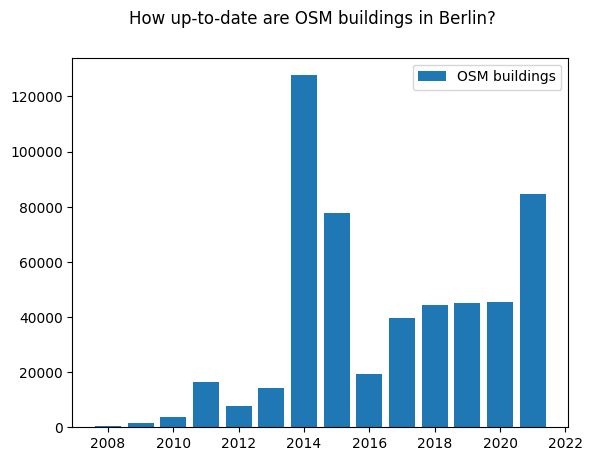

In [29]:
import matplotlib.pyplot as plt


dates = []
values = []
for r in result:
    year = datetime.fromisoformat(r["fromTimestamp"].replace("Z", "")).year
    dates.append(year)
    values.append(r["value"])
   
fig, ax = plt.subplots()
ax.bar(dates, values, label="OSM buildings")
ax.legend()
fig.suptitle("How up-to-date are OSM buildings in Berlin?")
plt.show()

## Request the ohsome quality analyst (OQT) API

OQT provides quality estimations of OpenStreetMap (OSM) data and uses the ohsome API.

OQT calls those estimations indicators.
Indicators are computed for a specific area (`bpolys`) and a certain set of aggregated OSM features (`layer`).

OQT offers two intrinsic quality estimation: the "Mapping Saturation" indicator and the "Currentness" indicator.

*Further Resource:* [Website](https://oqt.ohsome.org) | [GitHub](https://github.com/GIScience/ohsome-quality-analyst) | [API](https://oqt.ohsome.org/api/docs)

### Currentness Indicator

The Currentness indicator works well with following layers:

- Building Count (`building_count`)
- Major Roads Count (`major_roads_count`)
- Amenities (`amenities`)

In [2]:
# Helper function to display OQT API response.

import json

from IPython.display import SVG, display
import requests
from termcolor import colored


def display_results(feature):
    name = feature["properties"]["name"]
    label = feature["properties"]["result"]["label"]
    color = feature["properties"]["result"]["label"]
    description = feature["properties"]["result"]["description"]
    svg = feature["properties"]["result"]["svg"]

    # print(json.dumps(result, indent=4))
    print(name)
    print("-" * len(name))
    print("Quality Label: " + colored(label, color))
    print("Result Description: " + description)
    display(SVG(svg))

Berlin
------
Quality Label: yellow
Result Description: In the last 3 years 29.51 % of the elements were edited the last time.
In the period from 4 to 7 years ago 26.82 % of the elements were edited the last time.
The remaining 43.67 % were last edited more than 8 years ago.
The median currentness of the 554099 features (Building Count) is 6 year(s).
It is likely that some features are up-to-date and some features are outdated.



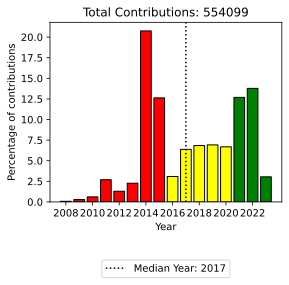

In [3]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "Currentness",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

display_results(response.json())

### Currentness Indicator for all districts in Berlin

The previous requests have been about one Area-of-Interest (AOI). OQT can compute the same Indicator for a number of AOIs given a GeoJSON FeatureCollection.

Lichtenberg
-----------
Quality Label: yellow
Result Description: In the last 3 years 38.85 % of the elements were edited the last time.
In the period from 4 to 7 years ago 38.4 % of the elements were edited the last time.
The remaining 22.75 % were last edited more than 8 years ago.
The median currentness of the 30176 features (Building Count) is 4 year(s).
It is likely that some features are up-to-date and some features are outdated.



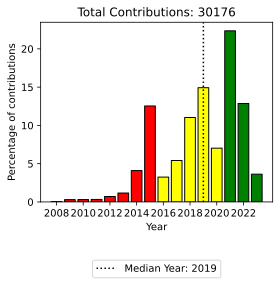

Charlottenburg-Wilmersdorf
--------------------------
Quality Label: yellow
Result Description: In the last 3 years 43.45 % of the elements were edited the last time.
In the period from 4 to 7 years ago 32.29 % of the elements were edited the last time.
The remaining 24.26 % were last edited more than 8 years ago.
The median currentness of the 27895 features (Building Count) is 4 year(s).
It is likely that some features are up-to-date and some features are outdated.



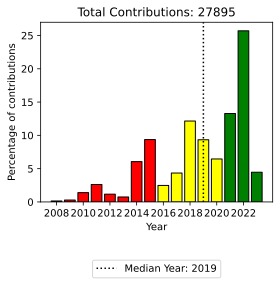

Pankow
------
Quality Label: yellow
Result Description: In the last 3 years 34.82 % of the elements were edited the last time.
In the period from 4 to 7 years ago 17.51 % of the elements were edited the last time.
The remaining 47.67 % were last edited more than 8 years ago.
The median currentness of the 75860 features (Building Count) is 6 year(s).
It is likely that some features are up-to-date and some features are outdated.



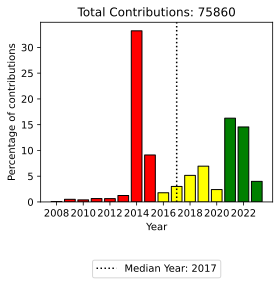

Marzahn-Hellersdorf
-------------------
Quality Label: yellow
Result Description: In the last 3 years 31.89 % of the elements were edited the last time.
In the period from 4 to 7 years ago 44.02 % of the elements were edited the last time.
The remaining 24.09 % were last edited more than 8 years ago.
The median currentness of the 45441 features (Building Count) is 5 year(s).
It is likely that some features are up-to-date and some features are outdated.



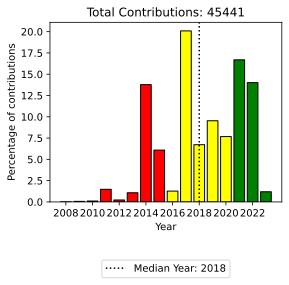

Neukölln
--------
Quality Label: yellow
Result Description: In the last 3 years 25.31 % of the elements were edited the last time.
In the period from 4 to 7 years ago 31.79 % of the elements were edited the last time.
The remaining 42.9 % were last edited more than 8 years ago.
The median currentness of the 43280 features (Building Count) is 6 year(s).
It is likely that some features are up-to-date and some features are outdated.



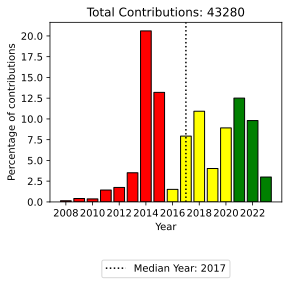

Tempelhof-Schöneberg
--------------------
Quality Label: red
Result Description: In the last 3 years 21.29 % of the elements were edited the last time.
In the period from 4 to 7 years ago 19.3 % of the elements were edited the last time.
The remaining 59.42 % were last edited more than 8 years ago.
The median currentness of the 50767 features (Building Count) is 8 year(s).
It is likely that many features are outdated.



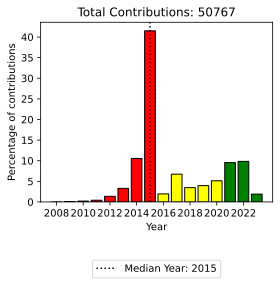

Friedrichshain-Kreuzberg
------------------------
Quality Label: yellow
Result Description: In the last 3 years 43.07 % of the elements were edited the last time.
In the period from 4 to 7 years ago 28.28 % of the elements were edited the last time.
The remaining 28.65 % were last edited more than 8 years ago.
The median currentness of the 16527 features (Building Count) is 3 year(s).
It is likely that some features are up-to-date and some features are outdated.



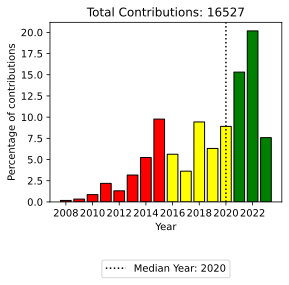

Treptow-Köpenick
----------------
Quality Label: yellow
Result Description: In the last 3 years 26.59 % of the elements were edited the last time.
In the period from 4 to 7 years ago 30.55 % of the elements were edited the last time.
The remaining 42.87 % were last edited more than 8 years ago.
The median currentness of the 59315 features (Building Count) is 5 year(s).
It is likely that some features are up-to-date and some features are outdated.



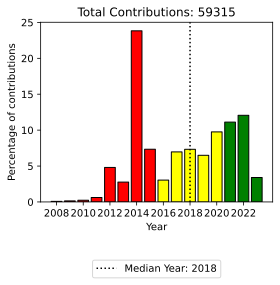

Steglitz-Zehlendorf
-------------------
Quality Label: yellow
Result Description: In the last 3 years 22.02 % of the elements were edited the last time.
In the period from 4 to 7 years ago 27.79 % of the elements were edited the last time.
The remaining 50.19 % were last edited more than 8 years ago.
The median currentness of the 64077 features (Building Count) is 7 year(s).
It is likely that some features are up-to-date and some features are outdated.



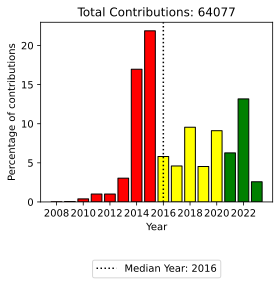

Mitte
-----
Quality Label: yellow
Result Description: In the last 3 years 41.35 % of the elements were edited the last time.
In the period from 4 to 7 years ago 28.82 % of the elements were edited the last time.
The remaining 29.82 % were last edited more than 8 years ago.
The median currentness of the 32206 features (Building Count) is 3 year(s).
It is likely that some features are up-to-date and some features are outdated.



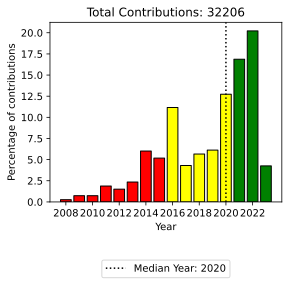

Spandau
-------
Quality Label: red
Result Description: In the last 3 years 23.3 % of the elements were edited the last time.
In the period from 4 to 7 years ago 23.54 % of the elements were edited the last time.
The remaining 53.16 % were last edited more than 8 years ago.
The median currentness of the 48907 features (Building Count) is 8 year(s).
It is likely that many features are outdated.



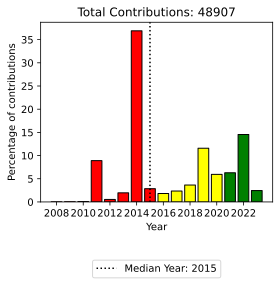

Reinickendorf
-------------
Quality Label: red
Result Description: In the last 3 years 25.71 % of the elements were edited the last time.
In the period from 4 to 7 years ago 16.41 % of the elements were edited the last time.
The remaining 57.88 % were last edited more than 8 years ago.
The median currentness of the 60221 features (Building Count) is 8 year(s).
It is likely that many features are outdated.



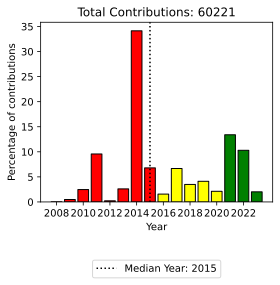

In [30]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

# load districts as GeoJSON FeatureCollection
with open("germany-berlin-districts.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "Currentness",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

features = response.json()["features"]
for feature in features:
    display_results(feature)